# **Chap4：循环神经网络RNN**

In [1]:
import tensorflow as tf
from matplotlib import pyplot as plt
import jieba
from tqdm import tqdm
import time
import numpy as np
from source.code import ch4
from source.code import utils

2023-07-10 11:03:33.433608: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-10 11:03:33.583149: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-10 11:03:33.615337: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-07-10 11:03:34.365372: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
# 如果你要在服务器上和别人共用GPU，可以设置你需要的显存资源
utils.gpu_limitation_config(memory=30,device=1)

## **4.5 机器翻译任务**

### **4.5.1 数据集准备**

**(1) 数据集导入**

下面我们展示另一种NLP中的常见任务，**机器翻译**，我们将演示**英文到中文的翻译**，首先，导入中英文平行对照文件 `../source/data/news_v16-en-zh.tsv`
* 每一行是一个句子对，中间用 `"\t"` 隔开
* **机器翻译相关的数据集可以在各开源网站找到，或者自己制作**

In [3]:
with open("../source/data/translation/news_v16-en-zh.tsv", "r", encoding="utf-8") as file:
    for i in range(5):
        line = file.readline()
        # 分别获取英文，中文
        en, zh = line.split("\t")
        print("源语句：", en)
        print("目标语句：", zh)

源语句： 1929 or 1989?
目标语句： 1929年还是1989年?

源语句： PARIS – As the economic crisis deepens and widens, the world has been searching for historical analogies to help us understand what has been happening.
目标语句： 巴黎-随着经济危机不断加深和蔓延，整个世界一直在寻找历史上的类似事件希望有助于我们了解目前正在发生的情况。

源语句： At the start of the crisis, many people likened it to 1982 or 1973, which was reassuring, because both dates refer to classical cyclical downturns.
目标语句： 一开始，很多人把这次危机比作1982年或1973年所发生的情况，这样得类比是令人宽心的，因为这两段时期意味着典型的周期性衰退。

源语句： Today, the mood is much grimmer, with references to 1929 and 1931 beginning to abound, even if some governments continue to behave as if the crisis was more classical than exceptional.
目标语句： 如今人们的心情却是沉重多了，许多人开始把这次危机与1929年和1931年相比，即使一些国家政府的表现仍然似乎把视目前的情况为是典型的而看见的衰退。

源语句： The tendency is either excessive restraint (Europe) or a diffusion of the effort (the United States).
目标语句： 目前的趋势是，要么是过度的克制（欧洲 ） ， 要么是努力的扩展（美国 ） 。



**(2) 预处理和词元化**

接下来，我们需要对文本序列进行**预处理**，并准备将中文和英文分别**词元化**

In [4]:
def preprocessing_en_zh(file : str, num_lines : int = None):
    """
    预处理英文-中文数据集
    """
    import re, jieba
    def no_space(char, prev_char):
        return char in set(",.!?:()‘’“”") and prev_char != " "
    
    # 打开读取文件
    with open(file, "r", encoding="utf-8") as file:
        lines = file.readlines()
        
    num_lines = num_lines if num_lines is not None else len(lines)

    source, target = [], [] # 保存源语句和目标语句

    for line in tqdm(lines[:num_lines]):
        # 分别获取英文，中文
        en, zh = line.split("\t")

        # 英文预处理
        # 1. '\u202f' 和 '\xa0' 替换为普通空格
        en = en.replace("\u202f", " ").replace("\xa0", " ")
        # 2. 全部转换为小写
        en = en.lower()
        # 3. 在单词和标点符号之间添加空格(在标点符号前添加空格，为了利用空格分词)
        en = [' ' + char if i > 0 and no_space(char, en[i - 1]) else char for i, char in enumerate(en)]
        en = ''.join(en)
        # 4. 利用空格分词
        en = en.split()

        # 中文预处理
        # 1. 用中文标点替换英文标点
        zh = zh.replace(",", "，").replace(".", "。").replace("?", "？").replace("!", "！")
        # 1. 用正则表达式保留中文字符
        zh = re.sub(r"[^\u4e00-\u9fa5，、。？！；：（）《》‘’”“0-9]", '', zh)
        # 2. 利用 jieba 分词
        zh = list(jieba.lcut(zh))

        # 将处理后的数据添加到列表中
        if 0 < len(en) < 100 and 0 < len(zh) < 100:
            source.append(en)
            target.append(zh)

    return source, target

备注：source和target是2D列表，每个元素都是一个句子的分词结果。

In [5]:
source, target = ch4.preprocessing_en_zh(file="../source/data/translation/news_v16-en-zh.tsv")

  0%|          | 0/322275 [00:00<?, ?it/s]Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.830 seconds.
Prefix dict has been built successfully.
100%|██████████| 322275/322275 [01:39<00:00, 3223.29it/s]


In [6]:
print("英语词元：",source[0])
print("中文词元：",target[0])

英语词元： ['1929', 'or', '1989', '?']
中文词元： ['1929', '年', '还是', '1989', '年', '？']


**我们绘制每个文本序列所包含的词元数量的直方图**，这可以帮助我们确认在训练时，**统一模型所处理文本序列的长度**

In [7]:
def plot_sentence_length_hist(source : list, target : list):
    fig = plt.figure(figsize=(5, 3))
    # 统计英文和中文的句子长度
    source_len = [len(sen) for sen in source]
    target_len = [len(sen) for sen in target]

    # 绘制英文和中文的句子长度直方图
    _,_,patches = plt.hist([source_len, target_len], bins=10, label=["source", "target"])
    # 显示条纹
    for patch in patches[1]:
        patch.set_hatch('///')
    plt.legend()
    plt.xlabel("# tokens per sentence")
    plt.ylabel("frequency")

可以观察到：
* 绝大部分序列，**词元化后的长度都小于 60**
* 对于大部分序列，**词元化后的长度介于 20 至 30**

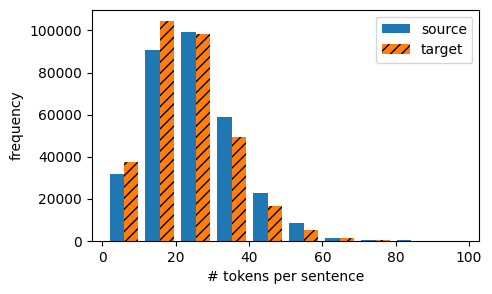

In [8]:
ch4.plot_sentence_length_hist(source, target)

**(3) 创建词表**

接下来，使用我们之前定义的 `Vocab` 类创建**中英文词表** `en_vocab` 和 `zh_vocab`

In [9]:
# 英文词表
en_vocab = ch4.Vocab(source, min_freq=2)
# 中文词表
zh_vocab = ch4.Vocab(target, min_freq=2)

In [10]:
# 词表大小
print("英文词表大小：", len(en_vocab))
print("中文词表大小：", len(zh_vocab))

英文词表大小： 52619
中文词表大小： 54082


**(4) 创建数据集**

语言模型中的**序列样本都有一个固定的长度** `num_steps`，即**时间步数**，无论这个样本是一个句子，或是句子的一部分，或横跨了多个句子，在**机器翻译**任务中，**每个样本是由源语句和目标语句组成的文本序列对**
* 不管来自源语句还是目标语句，每个文本序列可能具有不同的长度

为了提高处理效率，让模型的计算变得简单，我们可以通过**截断**（truncate）和**填充**（padding）来**将所有的文本序列处理成为相同的长度** `num_steps`，这样**便于将文本数据制作成为批量供模型使用**
* 当文本序列的词元数目少于 `num_steps` 时，我们在其末尾添加特殊词元 `<pad>`
* 当文本序列的词元数目超过 `num_steps` 时，我们将截断文本序列超出 `num_steps` 的部分，丢弃剩余词元

In [11]:
def truncate_padding(line : list, num_steps : int, padding_token : int):
    """
    截断或者填充句子
    """
    if len(line) > num_steps:
        # 截断句子
        return line[:num_steps]
    else:
        # 填充句子
        return line + [padding_token] * (num_steps - len(line))

In [12]:
# 截断或者填充句子到 10 个词元
sentence = source[0]
# 转换为索引
sentence_idx = en_vocab[sentence]
sentence_done = ch4.truncate_padding(line=en_vocab[source[0]], num_steps=10, padding_token=en_vocab["<pad>"])

print("原始词元：", sentence)
print("词元索引：", sentence_idx)
print("截断和填充后词元索引：", sentence_done)

原始词元： ['1929', 'or', '1989', '?']
词元索引： [6725, 41, 2721, 96]
截断和填充后词元索引： [6725, 41, 2721, 96, 3, 3, 3, 3, 3, 3]


最后，我们定义一个函数 `build_translation_array()`，可以**将文本序列转换成小批量数据集用于训练**，我们将特定的词元 `<eos>` **添加到所有序列的末尾**，用于表示一段序列的结束
* 在翻译时，这能让模型通过一个词元接一个词元地生成序列进行预测时，生成到 `<eos>` 时意识到**序列生成工作结束**
* 此外，我们统计**每个文本序列的有效长度** `valid_len` ，**统计长度时去除了填充词** `<pad>`，在之后介绍的模型中会需要这个长度信息

In [13]:
def build_translation_array(tokens : list, vocab, num_steps):
    """
    将文本序列转换为训练用的批量数据
    """
    # 将文本词元转换为词元索引
    tokens = [vocab[line] for line in tokens] # 字符串数值化
    # 在句子末尾添加结束标记 <eos>
    tokens = [line + [vocab["<eos>"]] for line in tokens]

    # 对句子进行截断和填充，转换为张量
    array = tf.constant([ch4.truncate_padding(line, num_steps, vocab["<pad>"]) for line in tokens])
    # 统计每个句子的有效长度
    valid_len = tf.reduce_sum(tf.cast(array != vocab["<pad>"], tf.int32), axis=1)

    return array, valid_len

**把所有的功能**用函数 `load_translation_en_zh` 进行封装，创建我们的数据迭代器

In [14]:
def load_translation_en_zh(file : str, batch_size : int, num_steps : int, num_lines : int=None):
    """
    ### 加载英文-中文翻译数据集
    
    Parameters
    ----------
    file : str
        数据集文件路径
    batch_size : int
        批量大小
    num_steps : int
        每个句子的时间步
    num_lines : int
        读取的行数
    
    Returns
    -------
    data_iter : tf.data.Dataset
        数据集迭代器
    src_vocab : Vocab
        源语言词表
    tgt_vocab : Vocab
        目标语言词表
    """
    # 读取数据集
    source, target = ch4.preprocessing_en_zh(file,num_lines)
    # 构建词表
    src_vocab = ch4.Vocab(source, min_freq=2)
    tgt_vocab = ch4.Vocab(target, min_freq=2)
    # 构建数据集
    src_array, src_valid_len = ch4.build_translation_array(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = ch4.build_translation_array(target, tgt_vocab, num_steps)

    # 构建数据集，包含四个元素
    dataset = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    # 创建迭代器
    data_iter = tf.data.Dataset.from_tensor_slices(dataset).batch(batch_size).shuffle(batch_size)

    return data_iter, src_vocab, tgt_vocab

测试各个函数接口工作是否正确

In [15]:
train_iter, src_vocab, tgt_vocab = ch4.load_translation_en_zh(
    file="../source/data/translation/news_v16-en-zh.tsv",batch_size=2, num_steps=10)
for X, X_valid_len, Y, Y_valid_len in train_iter:
    print('X:', tf.cast(X, tf.int32))
    print('X的有效长度:', X_valid_len)
    print('Y:', tf.cast(Y, tf.int32))
    print('Y的有效长度:', Y_valid_len)
    break

100%|██████████| 322275/322275 [01:40<00:00, 3210.05it/s]
2023-06-20 20:24:15.860600: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-20 20:24:21.587415: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30963 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:1a:00.0, compute capability: 7.0
2023-06-20 20:24:21.588824: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 984 MB memory:  -> device: 1, name: Tesla V100-SXM2-32GB, pci bus id: 0000:1b:00.0, compute capability: 7.0
2023-06-20 20:24:21.590436: I tensorflow/core/common_runtime/g

X: tf.Tensor(
[[ 6725    41  2721    96     2     3     3     3     3     3]
 [  837    16    18     5    49   113 11488     9 19311     4]], shape=(2, 10), dtype=int32)
X的有效长度: tf.Tensor([ 5 10], shape=(2,), dtype=int32)
Y: tf.Tensor(
[[6792   25  273 2619   25   91    2    3    3    3]
 [ 909  299 1599  377 3108    7 2452    5  480   68]], shape=(2, 10), dtype=int32)
Y的有效长度: tf.Tensor([ 7 10], shape=(2,), dtype=int32)


### **4.5.2 编码器和解码器模型**

机器翻译所要实现的是一个**序列转换**（从源语句，翻译到目标语句），其**输入和输出都是长度可变的序列**，为了处理这种**输入和输出有差异的问题**，人们设计了包含两个组件的**编码器-解码器**模型架构：
* **编码器**（**encoder**）：接收一个**长度可变**的序列作为输入，并将其转换为**具有固定形状的编码状态**
* **解码器**（**decoder**）：接收**编码器编码**得到的**固定形状的编码状态**作为输入，然后映射到**长度可变的输出序列**

**编码器-解码器**架构如下图所示：

<img src="../source/Chap4/编码器解码器.svg" width=600>

在我们机器翻译的例子中：
* 给定输入序列 "How are you today ?"，**编码器会将句子包含的语义信息编码到一个状态** $H$
* 解码器**接收这个状态** $H$，然后一个词接一个词的生成翻译结果 "你今天怎么样？"

**编码器-解码器**的这种基本思想现在已经成为很多深度学习模型的基本框架
* 例如**文本生成图像**的模型，可以设计一个编码器将用户的绘图需求文本转换到隐状态，然后让解码器将这个隐状态解码为图像输出

在这一节，我们先定义几个抽象的类 `Encoder`，`Decoder` 和 `EncoderDecoder` 来演示**编码器-解码器**模型的工作流程
* 后续基于**编码器-解码器**架构实现的模型，可以直接继承这几个抽象类

**(1) 编码器**

在编码器接口中，我们只指定长度可变的序列作为编码器的输入 `inputs`
* 任何继承这个 `Encoder` 基类的模型将完成模型的推理逻辑

In [16]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Encoder, self).__init__(**kwargs)
    
    def call(self, inputs, *args, **kwargs):
        raise NotImplementedError

**(2) 解码器**

在解码器接口中：
* 我们新增一个 `init_state()` 函数，它用于将**编码器的输出** `enc_outputs` **转换为编码后的状态**
* `init_state()` 可能需要额外的输入，例如**输入序列的有效长度** `valid_len`
* 为了逐个生成长度可变的词元序列，解码器在每个时间步都会将**输入** `inputs`（例如上一个时间步的词元） 和**编码后的状态** `state` **映射成当前时间步的输出词元**

In [17]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Decoder, self).__init__(**kwargs)
    
    def init_state(self, enc_outputs, enc_valid_len=None, *args, **kwargs):
        raise NotImplementedError

    def call(self, inputs, state, *args, **kwargs):
        raise NotImplementedError

**(3) 合并编码器-解码器**

**编码器-解码器**架构包含了**一个编码器和一个解码器**
* 模型还拥有可选的额外的参数（例如**有效长度** `valid_len`），包含在 `call()` 方法的 `*args, **kwargs` 中
* 在前向传播中，**编码器的输出用于生成编码状态**，这个状态又**被解码器作为其输入的一部分**

In [18]:
class EncoderDecoder(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
    
    def call(self, enc_inputs, dec_inputs, *args, **kwargs):
        # 编码器负责将输入序列编码为隐状态
        enc_outputs = self.encoder(enc_inputs, *args, **kwargs)
        # 解码器负责根据编码器的输出和输入序列来预测输出序列
        dec_state = self.decoder.init_state(enc_outputs, *args)
        return self.decoder(dec_inputs, dec_state, **kwargs)

编码器和解码器相关的三个类 `Encoder`，`Decoder`，`EncoderDecoder` 已经写入了 `../source/code/utils.py` 中，下面我们将演示借助 RNN 来实现一个具体的**编码器-解码器机器翻译模型**

### **4.5.3 用 RNN 实现机器翻译模型**

本节，我们用两个循环神经网络的**编码器-解码器**模型，实现机器翻译任务的这种**序列到序列**（sequence to sequence，称为**seq2seq**）的学习任务
* RNN 编码器使用长度可变的序列作为输入，将其**转换为固定形状的隐状态** $H$
* 换言之，**输入序列的信息被编码到隐状态中**，这个隐状态大家又称为**上下文信息**
* 为了连续生成输出序列的词元，另一个 RNN 模型作为解码器，**基于输入序列的编码信息**，和**输出序列已经看见的或者已经生成的词元**来预测下一个词元

整个模型结构如下图所示：
* 特定的词元 `<eos>` 表示**序列结束**，一旦模型输出 `<eos>` 就停止预测
* 在 RNN 解码器的**初始化时间步**，我们将特殊词元 `<bos>`（表示**序列开始**）作为 $t=1$ 时刻的观测，用来预测下一个待翻译的词
* 我们可以使用**RNN 编码器最终的隐状态**来**初始化 RNN 解码器的隐状态**，以便**将编码器收集到的源语句的上下文信息传递给解码器使用**
* 或者，我们也可以将**RNN 编码器最终的隐状态作为 RNN 解码器输入特征的一部分**
* **真实的翻译结果作为标签**，RNN 解码器不断向后预测下一个词元，然后计算损失函数

<img src="../source/Chap4/RNN编码器解码器.png" width=800>

接下来，我们具体看模型的实现细节

**(1) 编码器**

我们使用 RNN 设计编码器，它**将长度可变的输入序列转换为形状固定的上下文状态变量** $c$，输入序列的有用信息全部被编码到 $c$ 中，考虑批量为 1 输入词元序列 $x_1,\cdots,x_T$，在时间步 $t$，RNN 将 $x_t$ 和上一时间步的隐藏状态 $h_{t-1}$ 变换到 $h_t$，我们用某个抽象的函数 $f$ 表示 RNN 实现的这种变换：
$$
h_t = f(x_t,h_{t-1})
$$

总之，**RNN 编码器需要通过拟合某个函数** $q$，**将所有时间步的隐藏状态转换为上下文变量** $c$：
$$
c = q(h_1,\cdots,h_T)
$$

比如一种最简单的方式是选择 $q(h_1,\cdots,h_T) = h_T$，则**下文变量仅仅是输入序列在最后时间步的隐状态**，到目前为止：
* 我们使用的是一个**单向循环神经网络**来设计编码器，隐状态 $h_t$ 只依赖于时间步 $t$ 及其之前的子序列信息（**包含之前的隐状态**）
* 我们也可以使用**双向循环神经网络构造编码器**，此时**隐状态会依赖于前向递推和后向递推得到的两个输入子序列**，因此隐状态 $h_t$ **对整个序列的信息都进行了编码**
* 思考，在**机器翻译**任务中，我们永远能够**看到完整的源语言文本**，而不像之前文本预测任务中那样只看到上文预测下文，所以**编码器使用双向循环神经网络是合理的**

下面我们来实现 RNN 编码器：
* 我们使用一个**嵌入层**将源语言词元映射到源语言的词空间
* RNN 模型选择了**多层的双向 GRU 模型**，你也可以更改为 LSTM
* 在实现时，请明晰每一层的计算逻辑，以及**模型所涉及的隐藏状态有哪些**

In [19]:
# RNN 编码器
class Seq2SeqEncoder(utils.Encoder):
    def __init__(self, vocab_size : int, embed_size : int, 
                 num_hiddens : int, num_layers : int, dropout : float=0, **kwargs):
        super().__init__(**kwargs)
        from keras.layers import Embedding, GRU, Bidirectional
        # 嵌入层
        self.embedding = Embedding(vocab_size, embed_size)
        # RNN 层
        self.rnn_layers = []
        for i in range(num_layers):
            self.rnn_layers.append(Bidirectional(
                GRU(num_hiddens, return_sequences=True, return_state=True, dropout=dropout)))
    
    def call(self, inputs, *args, **kwargs):
        # 输入形状：(batch_size, num_steps)
        X = self.embedding(inputs) # 先进行词嵌入

        # 保存每一层最终的隐状态
        state = []
        for layer in self.rnn_layers:
            X, *layer_state = layer(X,**kwargs)
            state.append(layer_state) # 保存每一层的隐状态
        
        return X, state

我们实例化编码器，并进行简单的实验，观察输出形状的变化

In [28]:
# 解码器词表大小，嵌入大小，隐藏单元个数，层数
vocab_size, embed_size, num_hiddens, num_layers = 10, 8, 16, 2
encoder = ch4.Seq2SeqEncoder(vocab_size=vocab_size, embed_size=embed_size, 
                             num_hiddens=num_hiddens, num_layers=num_layers)
# 输入序列特征
X = tf.zeros((4, 7)) # (batch_size, num_steps)

# 输出和隐藏状态
Y, state = encoder(X,training=False)
print("输出形状：", Y.shape) # (batch_size, num_steps, 2*num_hiddens)
print("编码器 RNN 层数：", len(state)) # num_layers
print("第一层隐藏状态数量：", len(state[0])) # 有两个隐藏状态，分别是前向和后向的隐藏状态
print("第一层前向隐藏状态形状：", state[0][0].shape) # (batch_size, num_hiddens)

输出形状： (4, 7, 32)
编码器 RNN 层数： 2
第一层隐藏状态数量： 2
第一层前向隐藏状态形状： (4, 16)


**(2) 解码器**

编码器输出的上下文变量 $c$ 对整个输入序列 $x_1,\cdots,x_T$ 进行编码，来自训练数据的输出序列 $y_1,y_2,\cdots,y_{T'}$ 对于每个时间步 $t'$（注意**这与输入序列的时间步** $t$ **没有关系**），解码器输出 $y_{t'}$ 的概率**取决于先前的输出子序列** $y_1,y_2,\cdots,y_{t'-1}$ 和**上下文变量** $c$：
$$
P(y_{t'} | y_1,\cdots,y_{t'-1},c)
$$

为了在序列上模型化这种条件概率，我们可以**使用另一个 RNN 作为解码器**，在输出序列的时间步 $t'$ 上
* RNN 将来自**上一时间步的输出** $y_{t'-1}$ 和**上下文变量** $c$ 作为其输入，上下文变量 $c$ **选取为 RNN 编码器最后一层隐状态**
    * 如果编码器使用了双向 RNN，则**最后一层包含两个隐藏状态**，可以把它们拼接在一起使用
* 然后**在当前时间步将它们**（$y_{t'-1}$ 和 $c$）和**上一时间步解码器的隐藏状态** $s_{t'-1}$ 转换为新的隐状态 $s_{t'}$
* 我们用抽象函数 $g$ 表示这种变换：
$$
s_{t'} = g(y_{t'-1},c,s_{t'-1})
$$

获得最后的隐藏状态后，把它接入**输出层**和 `softmax` 变换，就可以得到目标词元 $y_{t'}$ 的概率分布了

在下面解码器的实现中，，注意一些细节：
* 我们**使用编码器最后一个时间步的隐状态来初始化解码器的隐状态**
    * 首先，这要求**RNN 编码器和 RNN 解码器具有相同数量的层和隐藏单元**
    * 如果 RNN 编码器使用了**双向模型**，则**每层会包含两个隐藏状态**，这时候有两种处理思路：
        * 选择其中一个，例如前向隐状态，去初始化 RNN 解码器的隐状态
        * 将两个隐状态拼接在一起使用，则此时要求 **RNN 解码器的隐藏单元数量是 RNN 编码器的两倍**
* 为了让**经过编码的输入序列的信息在每个时间步都能利用**，上下文变量 $c$ **在所有时间步与解码器的输入进行拼接**
* 为了预测输出词元的概率分布，在 RNN 解码器的**最后一层使用全连接层来变换隐状态**

In [21]:
class Seq2SeqDecoder(utils.Decoder):
    def __init__(self, vocab_size : int, embed_size : int, 
                 num_hiddens : int, num_layers : int, dropout : float=0, **kwargs):
        super().__init__(**kwargs)
        from keras.layers import Embedding, GRU, Dense
        # 嵌入层
        self.embedding = Embedding(vocab_size, embed_size)
        # RNN 层
        self.rnn_layers = []
        for i in range(num_layers):
            self.rnn_layers.append(GRU(num_hiddens, return_sequences=True, return_state=True, dropout=dropout))
        # 输出层
        self.dense = Dense(vocab_size, activation='softmax')
    
    def init_state(self, enc_outputs, enc_valid_len=None, *args, **kwargs):
        # enc_outputs 包含两个元素：Y 和 state
        # Y 是编码器最后一层的输出，形状：(batch_size, num_steps, 2*num_hiddens)
        # state 是编码器每一层最后时间步的隐藏状态组成的列表
            # 如果编码器是单向 RNN，则每个元素形状：(batch_size, num_hiddens)
            # 如果编码器是双向 RNN，则包含两个隐状态，每个形状：(batch_size, num_hiddens)
        # 返回一个包含 num_layers 个元素的列表
        state = enc_outputs[1]

        # 我们将前向和后向的隐藏状态拼接在一起
        # 现在每个元素的形状：(batch_size, 2*num_hiddens)
        state = [tf.concat(layer_state, axis=-1) for layer_state in state]
        return state

    def call(self, inputs, state, *args, **kwargs):
        # 输入 inputs 形状：(batch_size, num_steps)
        # state 是包含 num_layers 个元素的列表，每个元素形状：(batch_size, 2*num_hiddens)
        X = self.embedding(inputs) # 先进行词嵌入，形状：(batch_size, num_steps, embed_size)

        # 用编码器最后一层隐藏状态构造上下文变量
        context = state[-1] # 形状：(batch_size, 2*num_hiddens)
        # 最后将 context 扩展到每个时间步，便于与输入 X 在特征维度上拼接
        # context 的形状：(batch_size, num_steps, 2*num_hiddens)
        context = tf.repeat(tf.expand_dims(context, axis=1), repeats=X.shape[1], axis=1)

        # 将输入和上下文变量拼接
        # X_and_context 的形状：(batch_size, num_steps, embed_size + 2*num_hiddens)
        X_and_context = tf.concat([X, context], axis=-1)

        # 依次计算每一层 RNN
        for i,layer in enumerate(self.rnn_layers):
            # X_and_context 的形状：(batch_size, num_steps, 2*num_hiddens)
            # X_and_context 在每层计算中相当于从 H^{(l)} 到 H^{(l+1)}
            X_and_context, state[i] = layer(X_and_context, state[i], **kwargs)
        
        # 输出形状：(batch_size, num_steps, vocab_size)
        output = self.dense(X_and_context)
        return output, state

接下来测试解码器的工作接口是否正常，并观察它的输出形状

In [22]:
# 注意 num_hiddens 和 num_layers 需要与编码器一致
# 如果编码器是双向 RNN，则解码器 num_hiddens 需要乘以 2
decoder = ch4.Seq2SeqDecoder(vocab_size=vocab_size, embed_size=embed_size,
                             num_hiddens=2*num_hiddens, num_layers=num_layers)

In [24]:
# 用编码器的输出初始化解码器的隐藏状态
state = decoder.init_state(encoder(X))

# 推理和计算
output, state = decoder(X, state, training=False)

print("输出形状：", output.shape) # (batch_size, num_steps, vocab_size)
print("解码器 RNN 层数：", len(state)) # num_layers
print("第一层隐藏状态形状：", state[0].shape) # (batch_size, 2*num_hiddens)

输出形状： (4, 7, 10)
解码器 RNN 层数： 2
第一层隐藏状态形状： (4, 32)


请注意，在上面的例子中，我们让**编码器和解码器使用了相同的** `vocab_size` 和 `embed_size`，事实上，编码器和解码器分别处源语言和目标语言
* 它们**应该有不同的词表大小**
* 也可以**选择不同的词嵌入维度**

最后，下图总结了 RNN 实现**编码器-解码器**模型的计算结构：

<img src="../source/Chap4/RNN实现编码器解码器模型.svg" width=500>

接下来我们讨论有关**模型训练和预测**相关的计算

**(3) 损失函数**

从 `<bos>` 开始，在每个时间步，**解码器预测了输出词元的概率分布**，类似于语言模型，通过**计算交叉熵损失函数来进行优化**，但直接计算会存在问题：
* 在训练数据生成过程中，我们强制**通过填充和截断把子序列变换到相同长度**，因此一些子序列的末尾是填充词 `<pad>`，我们**应该将填充词元的预测排除在损失函数的计算之外**
* 我们可以定义一个 `sequence_mask` 函数，通过**零值化来屏蔽不相关的项**（即去除掉填充的部分），以便后面**任何不相关预测的计算都是与零的乘积**，结果都等于零


In [26]:
# 在序列中屏蔽不相关的项
def sequence_mask(X : tf.Tensor, valid_len : tf.Tensor, value : float = 0):
    # X 形状：(batch_size, num_steps) 或者 (batch_size, num_steps, p)
    # valid_len 形状：(batch_size,)
    maxlen = X.shape[1] # 序列长度
    
    # lens 生成从 0 到 maxlen-1 的序列
    lens = tf.range(start=0, limit=maxlen, dtype=tf.float32)[None, :] # 形状：(1, num_steps)
    # valid_len[:, None] 将 valid_len 的形状变换为 (batch_size, 1)
    valid_len = tf.cast(valid_len[:, None], dtype=tf.float32) # 形状：(batch_size, 1)
    # 利用广播机制生成掩码 mask，形状：(batch_size, num_steps)
    # mask[i, j] = 1 if lens[j] < valid_len[i]; 0 otherwise
    mask = lens < valid_len
    
    # 分两种情况，将 mask 为 0 的元素替换为 value
    # 1. X 是一个三维张量，形状 (batch_size, num_steps, p)
    # 需要把 mask 也变成三维张量，形状 (batch_size, num_steps, 1)
    if len(X.shape) == 3:
        return tf.where(tf.expand_dims(mask, axis=-1), X, value)
    # 2. X 是一个二维张量，形状 (batch_size, num_steps)
    # 则保持 mask 是一个二维张量
    else:
        return tf.where(mask, X, value)

`sequence_mask()` 已经被写入 `../source/code/utils.py` 中

我们来测试一下函数的计算效果，可以看到**超出** `valid_len` **长度的部分被 mask 为零**

In [27]:
# 二维张量输入
X = tf.constant([[1, 2, 3], 
                 [4, 5, 6]])
utils.sequence_mask(X, valid_len=tf.constant([1, 2]))

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[1, 0, 0],
       [4, 5, 0]], dtype=int32)>

In [28]:
# 三维张量输入
X = tf.ones((2,3,4))
utils.sequence_mask(X, valid_len=tf.constant([1, 2]))

<tf.Tensor: shape=(2, 3, 4), dtype=float32, numpy=
array([[[1., 1., 1., 1.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [0., 0., 0., 0.]]], dtype=float32)>

现在，我们可以通过扩展softmax交叉熵损失函数来遮蔽不相关的预测
* 最初，所有预测词元的掩码 mask 都设置为 1
* 一旦给定了**有效长度** `valid_len`，**与填充词元对应的掩码将被设置为 0**
* 最后，**将所有词元的损失乘以掩码**，以过滤掉损失中填充词元产生的不相关预测

In [28]:
class MaskedSoftmaxCELoss(tf.keras.losses.Loss):
    def __init__(self, valid_len, **kwargs):
        # 初始化父类参数 reduction='none'，表示不对损失求均值
        super().__init__(reduction='none',**kwargs)
        self.valid_len = valid_len
    
    def call(self, y_true, y_pred):
        # y_true 形状：(batch_size, num_steps)
        # y_pred 形状：(batch_size, num_steps, vocab_size)
        # 初始化权重，形状：(batch_size, num_steps)
        weights = tf.ones_like(y_true, dtype=tf.float32)
        # 通过 sequence_mask 函数将不相关项的权重设为 0
        weights = utils.sequence_mask(weights, self.valid_len)

        # 计算无掩码的交叉熵损失
        loss_func = tf.keras.losses.SparseCategoricalCrossentropy(reduction='none')
        unweighted_loss = loss_func(y_true, y_pred) # 形状：(batch_size, num_steps)

        # 将不相关项的损失也设为 0
        # 为了演示，我们这里仅对时间步聚合，保留批量大小维度
        weighted_loss = tf.reduce_mean((unweighted_loss*weights), axis=1)
        return weighted_loss

`MaskedSoftmaxCELoss` 已经被写入 `../source/code/utils.py` 中

我们来**检查损失函数的工作是否正确**，可以看到 `valid_len = 0` 的批量，**对应的损失为零**

In [29]:
# batch_size = 3, num_steps = 4, vocab_size = 5
y_pred = tf.random.uniform((3,4,5))
y_true = tf.zeros((3,4), dtype=tf.int32)

# 有效长度
valid_len = tf.constant([4, 2, 0])
loss = utils.MaskedSoftmaxCELoss(valid_len)
loss(y_true, y_pred)

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([1.7980366, 0.6846905, 0.       ], dtype=float32)>

**(4) 模型训练**

在下面的循环训练过程注意：
* 特定的**序列开始词元** `<bos>` 是和**原始的输出序列**（不包括序列的结束词 `<eos>`）拼接在一起作为解码器的输入，这样子相当于将 $y_1,y_2,\cdots,y_{T'}$ **右移一位**，在 $t'$ 时刻，模型的输入是 $y_{t'-1}$，然后预测 $y_{t'}$
    * 即观测到 `<bos>` 要预测 $y_1$，观测到 $y_1$ 时需要预测 $y_2$，以此类推
    * 这被称为**强制教学**，因为原始的正确输出序列（即标签数据）被送入解码器作为输入，而**真实情况下，我们只可能将来自上一步的预测值作为解码器下一步的输入**

In [30]:
def train_seq2seq(model, data_iter, tgt_vocab, Epochs : int=100, lr : float=0.01, verbose : int=1):
    # 初始化优化器
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    animator = utils.Animator(xlabel='epoch', ylabel='loss',
                              xlim=[1, Epochs], legend=['train'])

    # 存储每个迭代周期的损失和样本量
    loss_batch, samples_batch = 0, 0
    # 记录单词处理速度
    speeds = []

    for epoch in range(Epochs):
        start = time.time() # 计时开始
        for batch in data_iter:
            # 分别拿到四个元素：编码器输入、编码器输入有效长度、解码器输入、解码器输入有效长度
            # X, Y 形状：(batch_size, num_steps)
            # X_valid_len, Y_valid_len 形状：(batch_size,)
            X, X_valid_len, Y, Y_valid_len = batch
            # 为解码器的输入添加 <bos>，形状：(batch_size, 1)
            bos = tf.reshape(tf.constant([tgt_vocab['<bos>']]*Y.shape[0]), (-1, 1))
            # 去掉解码器输入的最后一个时间步，在开头加上 <bos>，保持形状不变
            dec_input = tf.concat([bos, Y[:, :-1]], axis=1)

            with tf.GradientTape() as tape:
                # 进行预测，计算损失
                # 注意我们将 X_valid_len 传入给模型，它作为 *args 的一部分
                # 但目前我们的模型并没有使用它，这在后续章节中会改变
                Y_hat, _ = model(X, dec_input, X_valid_len, training=True)
                loss_func = utils.MaskedSoftmaxCELoss(Y_valid_len)
                loss = loss_func(Y, Y_hat) # 形状：(batch_size,)
            weights = model.trainable_variables
            grads = tape.gradient(loss, weights)
            grads = utils.grad_clipping(grads, 1) # 梯度裁剪
            optimizer.apply_gradients(zip(grads, weights))

            # 将该批量的损失函数值加到总损失函数值上
            num_tokens = tf.reduce_sum(Y_valid_len).numpy()
            loss_batch += tf.reduce_sum(loss).numpy()
            samples_batch += num_tokens
        
        end = time.time() # 计时结束
        speeds.append(samples_batch / (end - start))

        if epoch == 0 or (epoch + 1) % verbose == 0:
            # 计算困惑都
            ce = tf.math.exp(loss_batch / samples_batch).numpy()
            animator.add(epoch + 1, [ce])
    
    print(f"平均 {np.mean(speeds):.1f} 词元/秒")
    return model

训练函数 `train_seq2seq` 已经写入 `../source/code/utils.py` 中

导入相关的数据集，设置相关的超参数，创建模型并训练模型
* 根据 4.4.1 节的探索，大部分**翻译文本的序列长度在 20 左右**，我们设置 `num_steps = 20`

In [4]:
embed_size, num_hiddens, num_layers, dropout = 64, 64, 2, 0.25
batch_size, num_steps = 512, 20

# 读取数据
train_iter, src_vocab, tgt_vocab = ch4.load_translation_en_zh(
    file="../source/data/translation/news_v16-en-zh.tsv",
    batch_size=batch_size, num_steps=num_steps)

# 创建编码器-解码器模型
encoder = ch4.Seq2SeqEncoder(vocab_size=len(src_vocab), embed_size=embed_size, 
                             num_hiddens=num_hiddens, num_layers=num_layers, dropout=dropout)
decoder = ch4.Seq2SeqDecoder(vocab_size=len(tgt_vocab), embed_size=embed_size, 
                             num_hiddens=2*num_hiddens, num_layers=num_layers, dropout=dropout)
model = utils.EncoderDecoder(encoder, decoder)

100%|██████████| 322275/322275 [01:22<00:00, 3885.84it/s]


平均 4198060.0 词元/秒


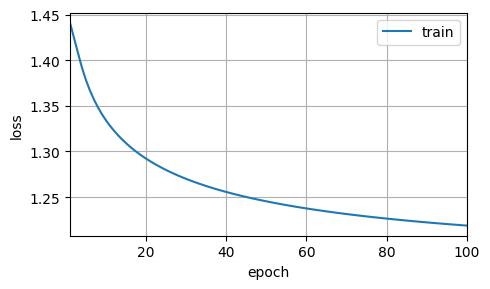

In [29]:
model = utils.train_seq2seq(model, train_iter, tgt_vocab, Epochs=100, lr=0.001)

----

训练这个模型花费了很大的力气，我们可以**保存该模型**，保存模型的方法有很多种，这里介绍**通过参数保存模型的方法**
* 我们将模型的参数保存为文件
* 下次再创建相同结构的一个模型时。只需要从本地加载参数文件

**(A) 模型保存**

通过模型实例的方法 `model.save_weights()` 就可以保存模型参数了，一般我们会将参数保存为 `.h5` 文件

```python
# 保存模型参数
model.save_weights("../source/model/ch4_translation_en_zh.h5")
```

**(B) 模型读取**

模型的读取部分稍微复杂一些，大致可以分为下面三个部分：
* 创建一个**新的相同的模型实例** `model`，需要**保证网络结构相同**（隐藏层数量，隐藏神经元大小等）
* `Tensorflow` 使用了**延后初始化策略**，即**模型实例化后，参数并未进行初始化**，在第一次调用模型时，才会初始化参数
    * 因此我们可以**生成符合模型输入要求的随机数据，调用一次模型，初始化模型参数**
* 通过 `model.load_weights()` 加载保存的模型参数文件

In [6]:
# 生成随机输入，调用一次模型，初始化模型
X = tf.zeros((1, 1), dtype=tf.int32)
Y = model(X, X, training=False)

In [7]:
# 加载模型参数
model.load_weights("../source/model/ch4_translation_en_zh.h5")

```python
# 第一步，创建相同结构的模型
encoder = ch4.Seq2SeqEncoder(vocab_size=len(src_vocab), embed_size=embed_size, 
                             num_hiddens=num_hiddens, num_layers=num_layers, dropout=dropout)
decoder = ch4.Seq2SeqDecoder(vocab_size=len(tgt_vocab), embed_size=embed_size, 
                             num_hiddens=2*num_hiddens, num_layers=num_layers, dropout=dropout)
model = utils.EncoderDecoder(encoder, decoder)

# 第二步，生成随机输入，调用一次模型，初始化模型
X = tf.zeros((1, 1), dtype=tf.int32)
Y = model(X, X, training=False)

# 第三步，加载模型参数
model.load_weights("../source/model/ch4_translation_en_zh.h5")
```

----

**(5) 模型预测**

为了采用**一个接着一个词元的方式预测输出序列**，每个解码器当前时间步的输入都**将来自于前一时间步的预测词元**
* 与训练类似，序列的**开始词元** `<bos>` **在初始时间步放入到解码器中**
* 当预测得到 `<eos>` 时，模型的预测结束

In [8]:
def predict_seq2seq(model, src_sentence : str, src_vocab, tgt_vocab, 
                    num_preds : int, num_steps : int, save_attention_weights : bool=False):
    """
    save_attention_weights : bool
        是否保存注意力权重，这在下一章的注意力机制中会用到
    """
    # 将源语句按词元切分
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [src_vocab['<eos>']]
    # 句子的有效长度
    enc_valid_len = tf.constant([len(src_tokens)])
    # 进行截断和填充
    src_tokens = ch4.truncate_padding(src_tokens, num_steps, src_vocab['<pad>'])
    enc_X = tf.expand_dims(tf.constant(src_tokens), axis=0) # 添加批量大小维度

    # 编码器输出，初始化解码器隐藏状态
    enc_outputs = model.encoder(enc_X, enc_valid_len, training=False)
    dec_state = model.decoder.init_state(enc_outputs, enc_valid_len)

    # 解码器的初始输入，添加批量大小维度
    dec_X = tf.expand_dims(tf.constant([tgt_vocab['<bos>']]), axis=0)
    output_seq, attention_weights = [], [] # 初始化输出序列和注意力权重
    for _ in range(num_preds):
        # 依次生成一个词元，更新解码器的隐藏状态
        # Y 的形状：(1, 1, vocab_size)
        Y, dec_state = model.decoder(dec_X, dec_state, training=False)
        # 从概率分布中获取词元
        dec_X = tf.argmax(Y, axis=2) # 形状：(1, 1)
        pred = dec_X[0][0].numpy()

        # 保存注意力权重
        if save_attention_weights:
            attention_weights.append(model.decoder.attention_weights)
        
        # 遇到 <eos> 结束预测
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred) # 添加到输出序列
    return "".join(tgt_vocab.to_tokens(output_seq)), attention_weights

函数 `predict_seq2seq()` 已经写入 `../source/code/utils.py` 了，便于后续章节使用

In [9]:
engs = ["how are you ?", 
        "peace is what we want .", 
        "he is my teacher and he teaches english .",
        "the chinese law prohibits citizens from drug trafficking ."]
for eng in engs:
    print(f"英文：{eng}")
    print(f"中文：{utils.predict_seq2seq(model, eng, src_vocab, tgt_vocab, num_steps=10, num_preds=10)[0]}")

英文：how are you ?
中文：你如何？
英文：peace is what we want .
中文：和平是我们的希望。
英文：he is my teacher and he teaches english .
中文：他是我的老师，他的作品是
英文：the chinese law prohibits citizens from drug trafficking .
中文：中国禁止中国的非法毒品和毒品走私。


**模型的翻译效果不理想，但基本单词的翻译是正确的**
* 后续章节我们会逐步解析 RNN 模型存在的问题，并改进这个结果

对于机器翻译任务，如何**评估翻译质量的好坏呢**，一种常用的方法是计算指标**BLEU**（bilingual evaluation understudy）
* BLEU 最先用于评估机器翻译任务，但现在它已经被广泛用于**测量许多应用的输出序列的质量**
* 原则上说，对于预测序列中的任意 n-gram 语法，BLEU 评估**这个语法是否出现在标签序列中**：
$$
\text{BLEU} = \exp\left( \min\left( 0, 1 - \frac{\text{len}_{\text{label}}}{\text{len}_{\text{pred}}} \right) \right)\prod_{n=1}^{k} p_n^{1/2^n}
$$

* $\text{len}_{\text{label}}, \text{len}_{\text{pred}}$ 是标签词元数和预测词元数
* $k$ 控制用于匹配的最长 n-gram 语法
* $p_n$ 表示 n-gram 语法的精确度，它是两个数量的比值
    * 分子是预测序列与标签序列中，匹配的 n-gram 语法的数量
    * 分母是预测序列中 n-gram 语法的数量
    * 比如给定标签序列 `A,B,C,D,E,F` 和预测序列 `A,B,B,C,D`，则
        * $n=1, p_1 = 4/5$，预测序列 1-gram 包含 `A,B,B,C,D` 共 5 个，标签中 `A,B,C,D` 共 4 个能匹配上
        * $n=2, p_2 = 3/4$，预测序列 2-gram 包含 `AB,BB,BC,CD` 共 4 个，标签中 `AB, BC, CD` 共 3 个能匹配上
        * $n=3, p_3 = 1/3$，预测序列 3-gram 包含 `ABB,BBC,BCD` 共 3 个，标签中 `BCD` 共 1 个能匹配上
        * $n=4, p_4 = 0$，预测序列 4-gram 包含 `ABBC,BBCD` 共 2 个，标签中没有能匹配上的 4-gram 语法

根据 BLEU 的定义，**当预测序列与标签序列完全相同时，BLEU 的值为 1**
* 由于 **n-gram 语法越长匹配难度越大**，因此 BLEU 为**更长的 n-gram 语法的精确度分配了更大的权重**，当 $p_n$ 固定时，$p_n^{1/2^n}$ 会随着 $n$ 的增长而增加，相当于给予更多的奖励
* 由于预测的序列越短获得的 $p_n$ 值越高，所以 **BLEU 累乘项之前的系数用于惩罚较短的预测序列**
    * 例如 $k=2$ 时，标签序列为 `A,B,C,D,E,F`，预测序列为 `A,B`，则 $p_1=p_2 = 1$，但乘法因子 $\exp(1 - 3)\approx 0.14$ 会极大的降低 BLEU

In [39]:
def chinese_bleu(label_seq : str, pred_seq : str, k : int):
    # 词元化
    import jieba, math, collections
    label_tokens, pred_tokens = list(jieba.cut(label_seq)), list(jieba.cut(pred_seq))
    # 序列长度
    label_len, pred_len = len(label_tokens), len(pred_tokens)
    
    # 初始化 BLEU 分数
    score = math.exp(min(0, 1 - label_len / pred_len)) # 惩罚项
    
    for n in range(1, k+1):
        num_matches = 0 # 匹配上的 n-gram 个数
        label_subs = collections.defaultdict(int) # 统计 label_tokens 中 n-gram 语法
        for i in range(label_len - n + 1):
            label_subs[''.join(label_tokens[i: i + n])] += 1
        for i in range(pred_len - n + 1):
            pred_sub = ''.join(pred_tokens[i: i + n]) # 选取 n-gram 语法
            # 在标签中匹配上了 n-gram 语法
            if label_subs[pred_sub] > 0:
                num_matches += 1 # 匹配上的 n-gram 个数加 1
                label_subs[pred_sub] -= 1 # 减去已经匹配上的 n-gram 语法
        # 计算 BLEU
        score *= math.pow(num_matches / (pred_len - n + 1), math.pow(0.5, n))
    return score

函数 `chinese_bleu()` 已经写入 `../source/code/utils.py` 了，便于我们后续章节使用

In [40]:
# 句子对
pairs = [["how are you ?", "你如何？",],
         ["peace is what we want .", "和平是我们所希望的。",],
         ["he is my teacher and he teaches english .", "他是我的老师，他教英语",],
         ["the chinese law prohibits citizens from drug trafficking .", "中国法律禁止公民毒品走私。"]]
# 评估模型
for en, zh in pairs:
    trans, _ = utils.predict_seq2seq(model, en, src_vocab, tgt_vocab, num_steps=10, num_preds=10)
    bleu = utils.chinese_bleu(zh, trans, k=2)
    print(f"{en} \n=> {trans}, bleu {bleu:.3f}")

how are you ? 
=> 你如何？, bleu 1.000
peace is what we want . 
=> 和平是我们的希望。, bleu 0.673


he is my teacher and he teaches english . 
=> 他是我的老师，他的作品是, bleu 0.669
the chinese law prohibits citizens from drug trafficking . 
=> 中国禁止中国的非法毒品和毒品走私。, bleu 0.396


### **4.5.4 束搜索**

下面我们介绍一种**语言模型预测的采样方法**，这可以让我们对相同的输入获得不同的预测输出结果

在之前所有语言模型的预测过程中，我们都采用**贪心预测**的想法，即在每个时间步的预测，都选取**下一个词概率分布的最大值点**，直到到达指定的预测词数 `num_preds` 或者预测出 `<eos>`：
$$
y_{t'} = \mathop{\arg\max}\limits_{y\in\mathcal{Y}} P(y|y_1,\cdots,y_{t'-1},c)
$$

假设我们有四个词元 `A, B, C, <eos>`，考虑四个时间步的预测，则预测输出过程如下图所示：

<img src="../source/Chap4/贪心预测.svg" width=300>

可以直接计算**贪心预测**得到的输出序列的概率为：
$$
P(y_1,y_2,y_3,y_4) = 0.5\times 0.4\times 0.4\times 0.6 = 0.048
$$

很显然，**贪心策略并不一定能取得关于整个序列的最优预测**，例如选取下面的预测结果，此时输出序列的概率为：
$$
P(y_1,y_2,y_3,y_4) = 0.5\times 0.3\times 0.6\times 0.6 = 0.054 > 0.048
$$

<img src="../source/Chap4/贪心预测失效.svg" width=300>

因此我们可以认为，序列 `ACB` 出现的可能性要比 `ABC` 更高，它应该是更优的输出序列
* 注意**下一个时间步的词元的概率分布会依赖于之前预测选择的结果**
    * 例如当我们在 $t=2$ 时选择预测词元 `C` 后，时间步 $t=3,4$ 的词元概率分布发生了改变
* 新序列 `ACB` 在**第二步选择了一个次优的词元**，却在整体上帮我们获得了更优的序列，这是**贪心算法做不到的**

那么如何获得潜在的更优的预测序列呢？一种最直观的想法是**穷举搜索**

我们**穷举地列举所有可能的输出序列及其条件概率**，然后将所有可能输出序列的概率排序，就可以得到最优质的预测序列
* 假设输出词表大小为 $|\mathcal{Y}|$，预测时间步为 $T'$，则穷举法的计算量为 $\mathcal{O}(|\mathcal{Y}|^{T'})$
* 当 $|\mathcal{Y}| = 10000$，$T' = 10$，我们需要评估 $10000^{10} = 10^{40}$ 个序列，这个**计算量是不可能实现的**
* 而**贪心搜索的评估量只有** $|\mathcal{Y}|\times T'$，因为只需要在每个时间步对 $|\mathcal{Y}|$ 个可能的输出选择最优即可

除了穷举搜索外，一种可行的搜索方法是**束搜索**（**Beam Search**），它是贪心搜索的一个改进版本
* 束搜索包含一个**超参数**，名为**束宽** $k$
* 在时间步 $t=1$，我们**选择具有最高条件概率的** $k$ 个词元，这 $k$ 个词元分别是 $k$ 个候选输出序列的第一个词元
* 在随后的每个时间步 $t$，基于上一个时间步 $t-1$ 的 $k$ 个候选输出序列，我们将继续**从** $k\cdot |\mathcal{Y}|$ **个可能的选择中**，**挑选出最高条件概率的** $k$ **个候选输出序列**

当 $k=2$ 时，束搜索如下进行：
* 在 $t = 1$ 时，假设具有最高条件概率 $P(y_1|c)$ 的词元是 $A,C$
* 在 $t = 2$ 时，我们计算下面 $2|\mathcal{Y}|$ 个条件概率：
    $$
    P(A,y_2|c) = P(A|c)\cdot P(y_2|A,c),\quad y_2\in\mathcal{Y} \\
    P(C,y_2|c) = P(C|c)\cdot P(y_2|C,c),\quad y_2\in\mathcal{Y} \\
    $$
    然后从 $2|\mathcal{Y}|$ 个条件概率中，**选择最大的两个**，例如 $P(A,B|c),P(C,E|c)$
* 在 $t = 3$ 时，继续计算下面 $2|\mathcal{Y}|$ 个条件概率：
    $$
    P(A,B,y_3|c) = P(A,B|c)\cdot P(y_3|A,B,c),\quad y_2\in\mathcal{Y} \\
    P(C,E,y_3|c) = P(C,E|c)\cdot P(y_3|C,E,c),\quad y_2\in\mathcal{Y} \\
    $$
    然后从 $2|\mathcal{Y}|$ 个条件概率中，**选择最大的两个**，例如 $P(A,B,D|c),P(C,E,D|c)$
* 示意图如下：

<img src="../source/Chap4/束搜索.svg" width=800>

最后，我们可以将得到的 $k$ 个候选输出**都认为是理想的输出预测**，然后输出从中随机抽取一个
* 因此有的语言模型每次给定相同的输入，模型的输出可能会不太一样
* 对于 $k$ 个候选序列，因为序列生成到 `<eos>` 就停止，因此 $k$ 个**序列长度可能不一样**
* 我们也可以计算 $k$ 个**候选序列输出条件概率的最大值**，作为**最优序列**输出：
    $$
    \frac{1}{L^a} \log P(y_1,\cdots,y_L|c) = \frac{1}{L^a}\sum_{t'=1}^{L} \log P(y_{t'}|y_1,\cdots,y_{t'-1},c)
    $$
    其中 $L$ 是候选序列的长度，$a$ 通常取 $a = 0.75$，因为一个较长的序列在求和中会有更多的对数项，因此**分母** $L^a$ **用于惩罚长序列**
* 束搜索的计算量是 $\mathcal{O}(k|\mathcal{Y}|T')$，这个结果介于**贪心策略和穷举策略**之间，事实上，**贪心策略等价于束宽** $k=1$ **的特殊类型的束搜索**，束搜索可以**调整** $k$ **在正确率和计算代价之间进行权衡**

束搜索的实现留作习题

----

### **练习**

1. 按照束搜索的逻辑，实现机器翻译任务的束搜索预测函数 `beam_search_predict_seq2seq()`
    1. 思考，**束搜索能用于前面章节的文本预测任务吗**？
    2. 从 `../source/model/ch4_translation_en_zh.h5` 加载训练好的模型，提供英文源语句给模型，设置束宽为5，每次给出 5 个可能的翻译结果，**测试束搜索的预测效果**

**提示**，你可以按如下方式，通过**加载参数文件**导入 `Tensorflow` 的模型

```python
# 创建模型
embed_size, num_hiddens, num_layers, dropout = 64, 64, 2, 0.25
batch_size, num_steps = 512, 20

# 读取数据
train_iter, src_vocab, tgt_vocab = ch4.load_translation_en_zh(
    file="../source/data/translation/news_v16-en-zh.tsv",
    batch_size=batch_size, num_steps=num_steps)

# 创建编码器-解码器模型
encoder = ch4.Seq2SeqEncoder(vocab_size=len(src_vocab), embed_size=embed_size, 
                             num_hiddens=num_hiddens, num_layers=num_layers, dropout=dropout)
decoder = ch4.Seq2SeqDecoder(vocab_size=len(tgt_vocab), embed_size=embed_size, 
                             num_hiddens=2*num_hiddens, num_layers=num_layers, dropout=dropout)
model = utils.EncoderDecoder(encoder, decoder)

# Tensorflow采用延后初始化
# 只有调用一次模型后，模型参数才会被初始化
X = tf.zeros((1,1))
Y = model(X, X)

# 加载模型参数
model.load_weights("../source/model/ch4_translation_en_zg.h5")
```

2. 让我们用所学到的 RNN 模型处理另一种 NLP 任务，**文本分类**，请按照如下顺序完成任务
    1. 首先，我们需要**导入数据集**，并准备训练模型输入相关的流水线
        1. 我们使用 `Tensorflow` 提供的 **IMDB 电影评论数据集**，通过 `TFDS` 导入，数据集中**每条文本序列对应一个二分类标签，1 表示文本内容是积极的，0 表示文本内容是消极的**
            ```python
            import tensorflow_datasets as tfds

            # 导入数据集
            dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True, as_supervised=True)
            train_ds, test_ds = dataset['train'], dataset['test'] # 获取训练集和测试集
            ```
        2. `TFDS` 返回的 `info` 包含了文本的编码器 `encoder`，它可以将英文字符串文本编码为词元索引
            ```python
            encoder = info.features['text'].encoder # 取出文本编码器
            print("词表大小：",encoder.vocab_size)

            string = "Hello Tensorflow."
            encoded_str = encoder.encode(string) # 将文本编码为词元索引
            decoded_str = encoder.decode(encoded_str) # 也可以将词元索引恢复到文本

            print("编码后词元索引：",encoded_str)
            print("解码后恢复的字符串：",decoded_str)
            ```
        3. `Tensorflow` 的 `TFDS` 提供的数据集接口自带了填充功能，设置超参数，`padded_batch()` 会将**每个批次的序列填充至批次中最长文本的长度**，因此 `padded_batch()` 所提供的**每个批量的文本序列时间步是不固定的**
            ```python
            buffer_size, batch_size = 10000, 64 # 设置缓冲区大小和批量大小
            
            # 设置填充和批量大小
            train_ds = train_ds.shuffle(buffer_size).padded_batch(batch_size)
            test_ds = test_ds.padded_batch(batch_size)
            ```
        4. 你可以尝试从 `train_ds` 或者 `test_ds` 中读取批量，来观察每个批量的数据
            ```python
            # 读取批量
            for x_batch, y_batch in train_ds:
                break
            ```
    2. 现在，我们来**搭建一个二分类模型来实现情感分类**
        1. 模型应该具有一个嵌入层，来将词元嵌入到词向量空间
        2. 设计你的 **RNN 层来提取文本序列的特征**，你可以考虑如下方面：
            1. 使用何种 RNN 模型？
            2. 是否使用双向 RNN 模型？
            3. 是否使用多层 RNN 模型？
            4. 应该用何种方式实现模型？`Sequential` 简洁实现，还是自定义继承 `tf.keras.Model` 类
            5. 模型的超参数应该如何设置？
        3. 设计模型后续的**输出层**，构建**二分类模型**，用于判断文本的积极/ 消极情绪
    3. 进行模型训练，绘制模型在**训练集上和测试集上的损失函数和准确率随迭代次数曲线**
        1. 考虑如何训练模型，你可以定义自己的训练函数
        2. 如果你使用了 `Sequential` 方法定义模型，那么利用 `model.compile()` 和 `model.fit()` 能够帮助你更快设置模型的训练
        3. 模型的在训练集和测试集上的准确率是多少？你的模型**出现了过拟合吗**？
    4. 定义模型**对单个样本的预测函数**，当给定一条文本序列时，函数能输出该文本的情绪是积极还是消极的

3. 在进入下一章之前，我们讨论 RNN 存在的问题和局限
    1. 从实验可以发现，RNN 参数比 CNN 少，训练速度却更慢，尤其是针对**长序列**，在下一章中我们会介绍**模型处理输入的并行度**的概念，在此之前，依靠直觉和你的理解尝试**解释 RNN 训练速度慢的原因**
    2. 即使使用了有记忆机制的 `GRU` 和 `LSTM`，对处理复杂的长序列时，**RNN 模型依然有些捉襟见肘**，联系 CNN 感受野的概念，我们也可以为 RNN 定义"感受野"，尝试解释**为什么 RNN 处理长序列时效果不理想**？

---